##Lab 9: Clustering

###**Overview**
###- Data prepocessing 
###- K-means (New!)
###- Agglomerative hierarchical clustering (Review from Lecture)
###- Evaluating/Understanding our clusters

####Before we begin: 

In [ ]:
# Import necessary modules
from google.colab import files
import io
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns

# Data for today

Employment counts from different industries from 2001-2020 in the province of Ontario. Data modified from [here](https://data.ontario.ca/en/dataset/labour-force-estimates-by-occupation/resource/0de3deb4-5379-41c6-b0d0-8aeafc9a1493). 

### I did some pre-processing to the data that we will use today, including:

- Removed total counts (only keeping counts from individual regions) because these are just aggregates of the regional counts. 
- Changed data from "long" format to "wide" format for both male and female counts, then merged the two wide dataframes.  Originially, the male and female data was separated and the male + female age group columns made up the rows.  

In [ ]:
# Read in data from github 
!wget "https://raw.githubusercontent.com/jlgrons/JSC270_Lab9/master/Data/Lab9_Data_20210302.csv"

--2022-03-22 16:51:04--  https://raw.githubusercontent.com/jlgrons/JSC270_Lab9/master/Data/Lab9_Data_20210302.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18410576 (18M) [text/plain]
Saving to: ‘Lab9_Data_20210302.csv.2’

Lab9_Data_20210302. 100%[===================>]  17.56M  --.-KB/s    in 0.1s    

2022-03-22 16:51:05 (171 MB/s) - ‘Lab9_Data_20210302.csv.2’ saved [18410576/18410576]



In [ ]:
data = pd.read_csv(r'Lab9_Data_20210302.csv', encoding= 'latin1', index_col=[0])
data = data.replace('-', 0)
data.head()

,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,Male_15-19,Male_20-24,Male_25-44,Male_45-54,...,Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over",job_num,job_descr
1,0 - Management occupations,Dec2001,Central region,Employment,2001,Dec,0.0,4.8,98.0,64.5,...,0.0,3.8,59.9,23.3,9.8,0.0,96.9,97.6,0,Management occupations
2,0 - Management occupations,Dec2001,Central region,Unemployment,2001,Dec,0.0,0.0,1.5,2.7,...,0.0,0.0,2.0,0.0,0.0,0.0,3.2,3.2,0,Management occupations
3,0 - Management occupations,Dec2001,Central region,Labour force,2001,Dec,0.0,4.8,99.5,67.2,...,0.0,3.8,61.8,24.3,10.0,0.0,100.1,100.8,0,Management occupations
4,0 - Management occupations,Dec2001,Central region,Unemployment rate,2001,Dec,0.0,0.0,1.5,4.0,...,0.0,0.0,3.2,0.0,0.0,0.0,3.2,3.2,0,Management occupations
5,0 - Management occupations,Dec2001,Eastern region,Employment,2001,Dec,0.0,0.0,27.1,18.6,...,0,0.0,17.7,9.1,2.9,1.8,30.1,31.9,0,Management occupations


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64464 entries, 1 to 82160
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Occupation                       64464 non-null  object 
 1   MONTH                            64464 non-null  object 
 2   GEOGRAPHY                        64464 non-null  object 
 3   LFS.CHARCT.                      64464 non-null  object 
 4   yr                               64464 non-null  int64  
 5   month                            64464 non-null  object 
 6   Male_15-19                       64464 non-null  object 
 7   Male_20-24                       64464 non-null  object 
 8   Male_25-44                       64464 non-null  object 
 9   Male_45-54                       64464 non-null  object 
 10  Male_55-64                       64464 non-null  object 
 11  Male_65 years and over           64464 non-null  object 
 12  Male_15-64 years  

In [ ]:
data.columns

Index(['Occupation', 'MONTH', 'GEOGRAPHY', 'LFS.CHARCT.', 'yr', 'month',
       'Male_15-19', 'Male_20-24', 'Male_25-44', 'Male_45-54', 'Male_55-64',
       'Male_65 years and over', 'Male_15-64 years',
       'Male_Total, 15 years and over', 'Female_15-19', 'Female_20-24',
       'Female_25-44', 'Female_45-54', 'Female_55-64',
       'Female_65 years and over', 'Female_15-64 years',
       'Female_Total, 15 years and over', 'job_num', 'job_descr'],
      dtype='object')

###Let's make some quick exploratory plots of our data

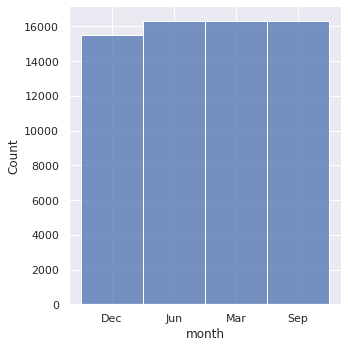

In [ ]:
# Data is collected quarterly at the same month every year
# Same occupational categories are being filled in each month of each year
sns.displot(data, x="month")
plt.show()

In [ ]:
# You can see the same pattern in the occupation variable - we have very regular data collection
pd.Series(data.Occupation).value_counts()

0 - Management occupations                                                                             1264
74 - Other installers, repairers and servicers and material handlers                                   1264
6 - Sales and service occupations                                                                      1264
62 - Retail sales supervisors and specialized sales occupations                                        1264
63 - Service supervisors and specialized service occupations                                           1264
64 - Sales representatives and salespersons - wholesale and retail trade                               1264
65 - Service representatives and other customer and personal services occupations                      1264
66 - Sales support occupations                                                                         1264
67 - Service support and other service occupations, n.e.c.                                             1264
7 - Trades, transport and eq

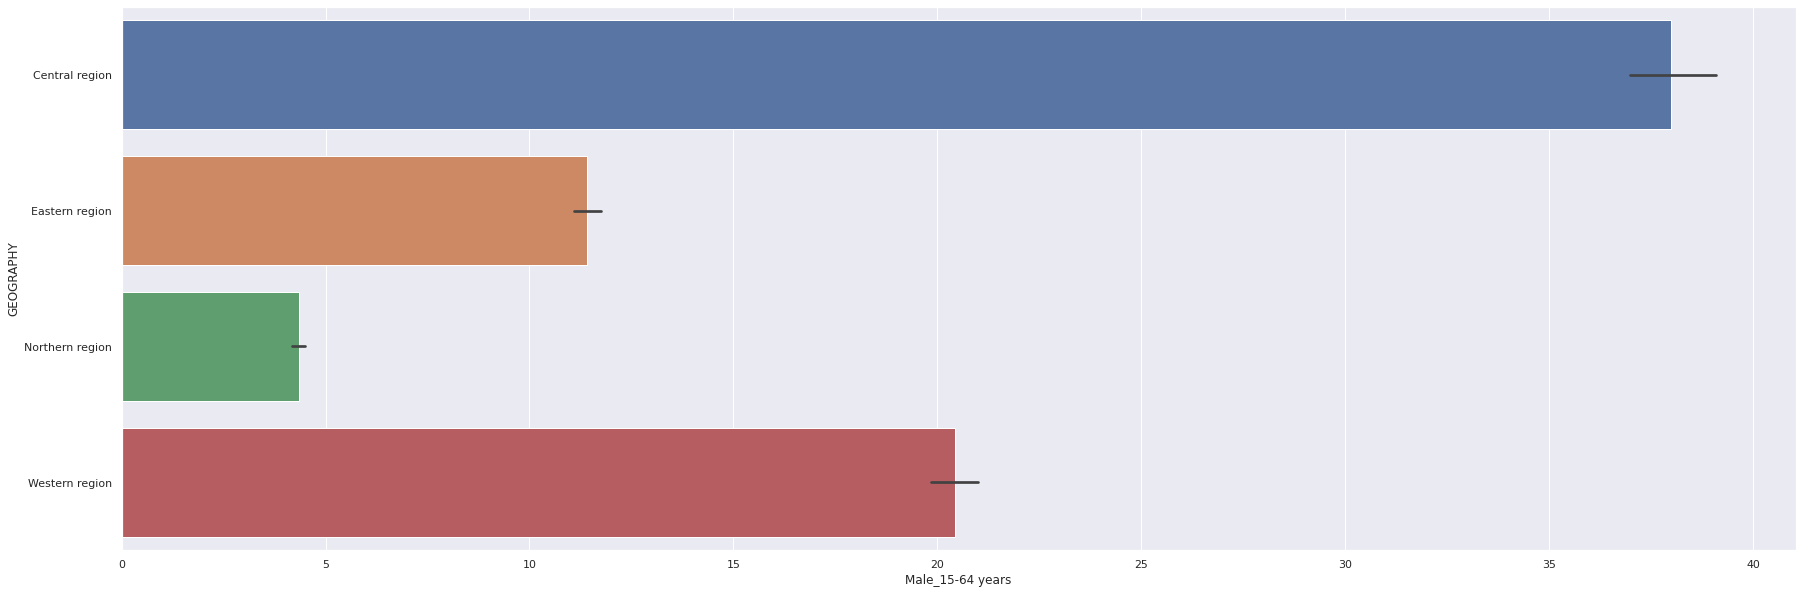

In [ ]:
# However, there is variability across geogrpahy within the different age and sex groups
# We'll see this pattern persist in the other categories
sns.barplot(x='Male_15-64 years', y='GEOGRAPHY', data=data)
plt.show()

###Check out data size

In [ ]:
data.shape ## data is *VERY* big, let's sub-sample it

(64464, 24)

In [ ]:
data_sub = data.sample(600, random_state=4321) ## sampling approximately 1% of the data - setting seed so we get same sample everytime
data_sub.head() 
## Note: In real life, we would de-dugging on a small subset and then eventually we 
## would figure out how to compute on the full data for the final analysis

,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,Male_15-19,Male_20-24,Male_25-44,Male_45-54,...,Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over",job_num,job_descr
56640,"7 - Trades, transport and equipment operators ...",Sep2008,Western region,Unemployment rate,2008,Sep,0.0,8.0,5.2,3.8,...,0.0,0.0,0.0,0.0,0.0,0.0,10.3,10.1,7,"Trades, transport and equipment operators and ..."
34586,41 - Professional occupations in law and socia...,Sep2012,Eastern region,Unemployment,2012,Sep,0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,"Professional occupations in law and social, co..."
37286,43 - Occupations in front-line public protecti...,Mar2009,Eastern region,Unemployment,2009,Mar,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0,0.0,0.0,43,Occupations in front-line public protection se...
49968,64 - Sales representatives and salespersons - ...,Mar2011,Eastern region,Unemployment rate,2011,Mar,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,Sales representatives and salespersons
38327,"44 - Care providers and educational, legal and...",Jun2002,Eastern region,Labour force,2002,Jun,0.0,0.0,1.6,0.0,...,2.9,0.0,6.0,1.7,0.0,0,12.2,12.2,44,"Care providers and educational, legal and publ..."


###Extract features and standardize rows

In [ ]:
# We'll cluster on the age and sex variables from our data
features = data_sub.iloc[:, 6:22]

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 56640 to 1380
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Male_15-19                       600 non-null    object 
 1   Male_20-24                       600 non-null    object 
 2   Male_25-44                       600 non-null    object 
 3   Male_45-54                       600 non-null    object 
 4   Male_55-64                       600 non-null    object 
 5   Male_65 years and over           600 non-null    object 
 6   Male_15-64 years                 600 non-null    float64
 7   Male_Total, 15 years and over    600 non-null    float64
 8   Female_15-19                     600 non-null    object 
 9   Female_20-24                     600 non-null    object 
 10  Female_25-44                     600 non-null    object 
 11  Female_45-54                     600 non-null    object 
 12  Female_55-64     

In [ ]:
# We'll scale the data which will help to normalize the variability across the counts
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(features)

#K-Means

## First, we'll go over the K-means algorithm.  We'll review some slides to get started.

###Do one round of clustering

In [ ]:
kmeans = KMeans(
    init = "random",
    n_clusters = 5,
    n_init = 10,
    max_iter = 300,
    random_state=4321
)

In [ ]:
kmeans.fit(scaled_feat)

KMeans(init='random', n_clusters=5, random_state=4321)

In [ ]:
## check out the labels
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1], dtype=int32)

How would we decide on the proper choice of K (the number of clusters)?  Let's go back to the slides.


###Let's evaluate using different numbers of clusters

In [ ]:
sil_coefs = []
clust_labels = []

for k in range(2, 15):
  print("clustering with " + str(k) + " clusters")
  kmeans = KMeans(n_clusters=k, n_init = 2, init="random", max_iter = 300, random_state=4321)
  kmeans.fit(scaled_feat)
  clust_labels.append(kmeans.labels_)
  score = silhouette_score(scaled_feat, kmeans.labels_)
  sil_coefs.append(score)

clustering with 2 clusters
clustering with 3 clusters
clustering with 4 clusters
clustering with 5 clusters
clustering with 6 clusters
clustering with 7 clusters
clustering with 8 clusters
clustering with 9 clusters
clustering with 10 clusters
clustering with 11 clusters
clustering with 12 clusters
clustering with 13 clusters
clustering with 14 clusters


###Plot silhouette statistics for each number of clusters

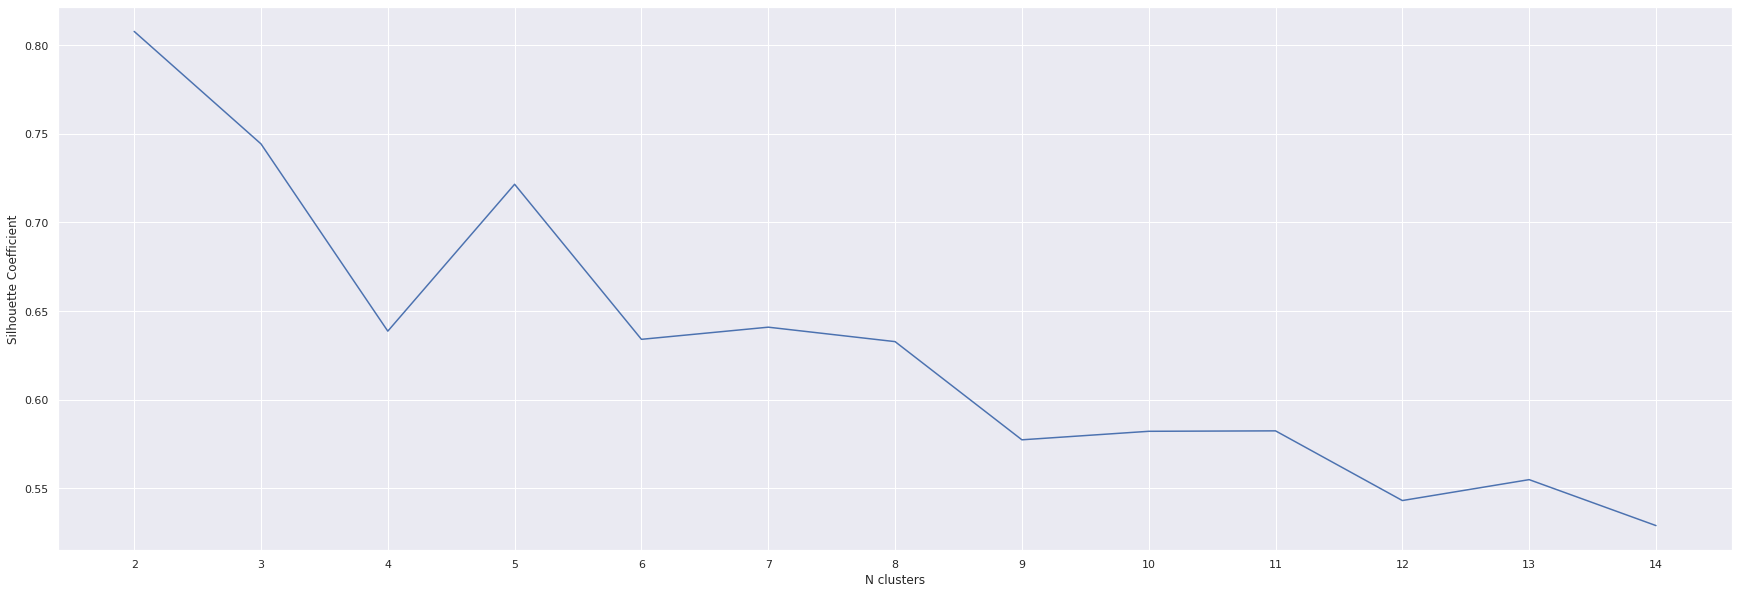

In [ ]:
# Let's take a look at the silhouette statistic 
plt.plot(range(2,15), sil_coefs)
plt.xticks(range(2,15))
plt.xlabel("N clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Q: What values of K would you be interested in investigating more?

### Let's check out the distribution of the data used for clustering and data not used for clustering for these choices of K.

###Data used for clustering

In [ ]:
n_clusters = 5

clust_df = pd.DataFrame(data=scaled_feat,columns=features.columns)
clust_df = clust_df.astype(float)
clust_df = clust_df.assign(clusters = clust_labels[n_clusters-2])

clust_mean_df = clust_df.groupby(['clusters']).mean()

# Average values of features (ie centroid) within each cluster 
clust_mean_df


,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over"
clusters,,,,,,,,,,,,,,,,
0,8.261844,8.146115,3.761846,3.686303,9.298115,5.494446,1.744333,1.679302,10.976469,8.306367,4.639332,6.309738,7.482456,-0.197940,2.062957,1.997871
1,-0.111488,-0.175664,-0.255720,-0.248360,-0.223986,-0.123947,-0.258279,-0.258879,-0.143029,-0.181606,-0.279664,-0.259395,-0.215402,-0.174126,-0.271748,-0.270267
2,0.205874,0.420252,0.791791,0.831356,0.573312,0.335471,0.897126,0.907304,0.353818,0.674072,1.434330,1.262400,0.893599,0.996422,1.495881,1.487735
3,3.566847,5.308191,6.067682,4.697302,4.855622,3.991780,7.277738,7.436233,3.758640,7.254340,9.897833,8.192621,8.894386,11.875719,11.702009,11.801570
4,0.384307,2.115605,5.686963,5.303359,3.323562,1.256351,5.665866,5.617108,-0.170757,0.035478,0.966568,0.737747,0.319940,-0.077014,0.790880,0.774179


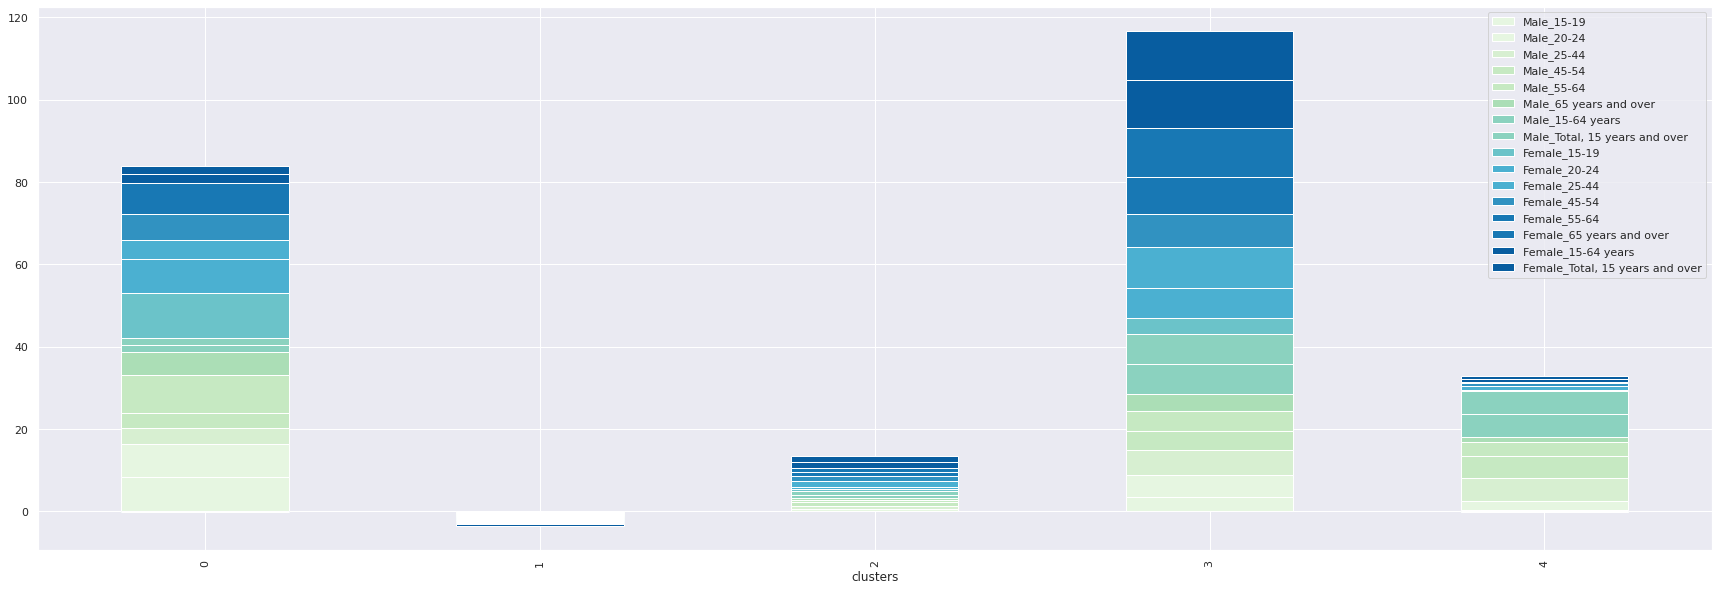

In [ ]:
# The plot helps us to understand the table above
sns.set()
clust_mean_df.plot(kind='bar',
                   stacked=True,
                   colormap=ListedColormap(sns.color_palette("GnBu", 10)),
                   figsize=(30,10))
plt.show()
# Note: Females are in the blue shade and males in the green

## Q: What patterns do you note?

###Data not used for clustering

In [ ]:
# Let's get a better sense using the rest of the features we didn't use for clustering
# n_clusters = 5

other_dat = data_sub.iloc[:, 0:5]
other_dat = other_dat.assign(clusters = clust_labels[n_clusters-2])
other_dat.clusters.astype(str)
other_dat.set_index('clusters')

other_dat.head()

,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,clusters
56640,"7 - Trades, transport and equipment operators ...",Sep2008,Western region,Unemployment rate,2008,1
34586,41 - Professional occupations in law and socia...,Sep2012,Eastern region,Unemployment,2012,1
37286,43 - Occupations in front-line public protecti...,Mar2009,Eastern region,Unemployment,2009,1
49968,64 - Sales representatives and salespersons - ...,Mar2011,Eastern region,Unemployment rate,2011,1
38327,"44 - Care providers and educational, legal and...",Jun2002,Eastern region,Labour force,2002,1


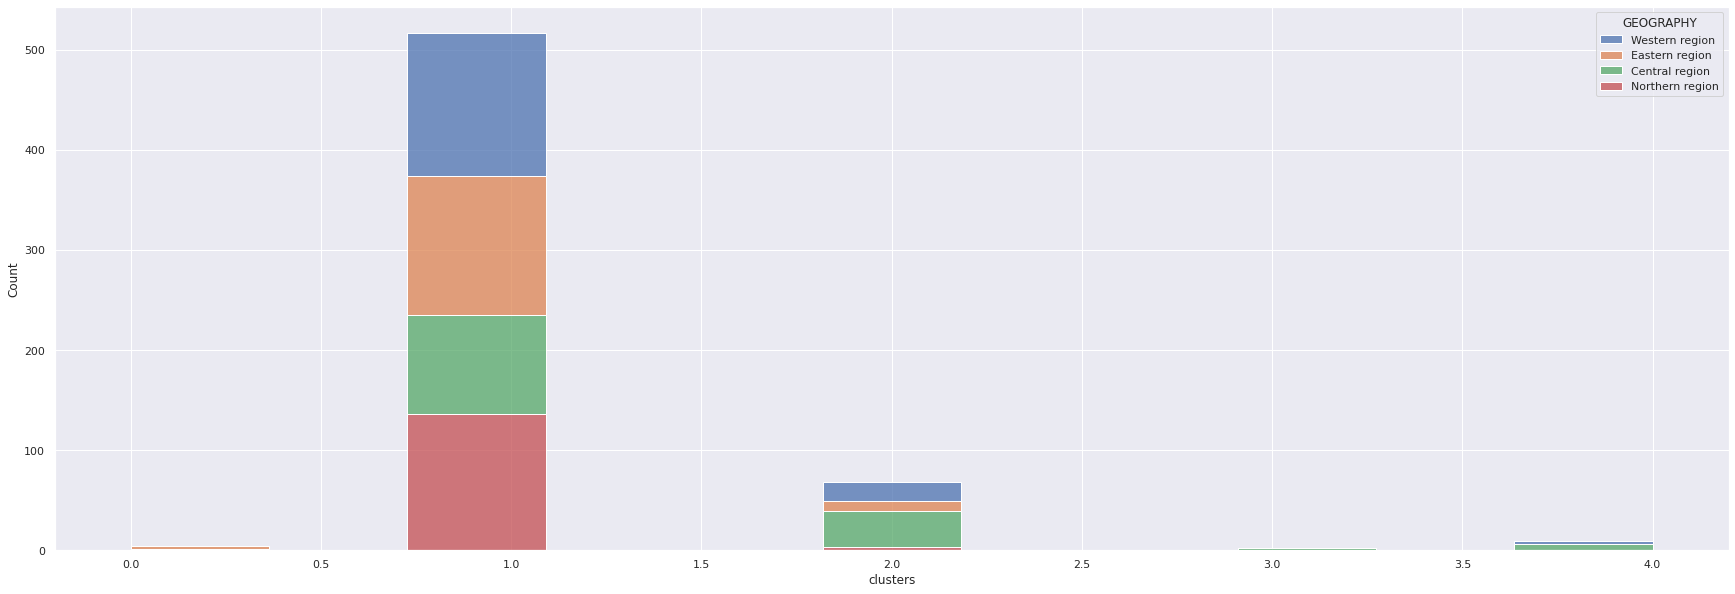

In [ ]:
sns.set(rc={'figure.figsize':(30,10)})
sns.histplot(other_dat, x = "clusters", hue = "GEOGRAPHY",
             multiple = "stack")
plt.show()

# Note the graph is treating clusters like a continuous variable! 

### Q: Do you see anything interesting in the plot?

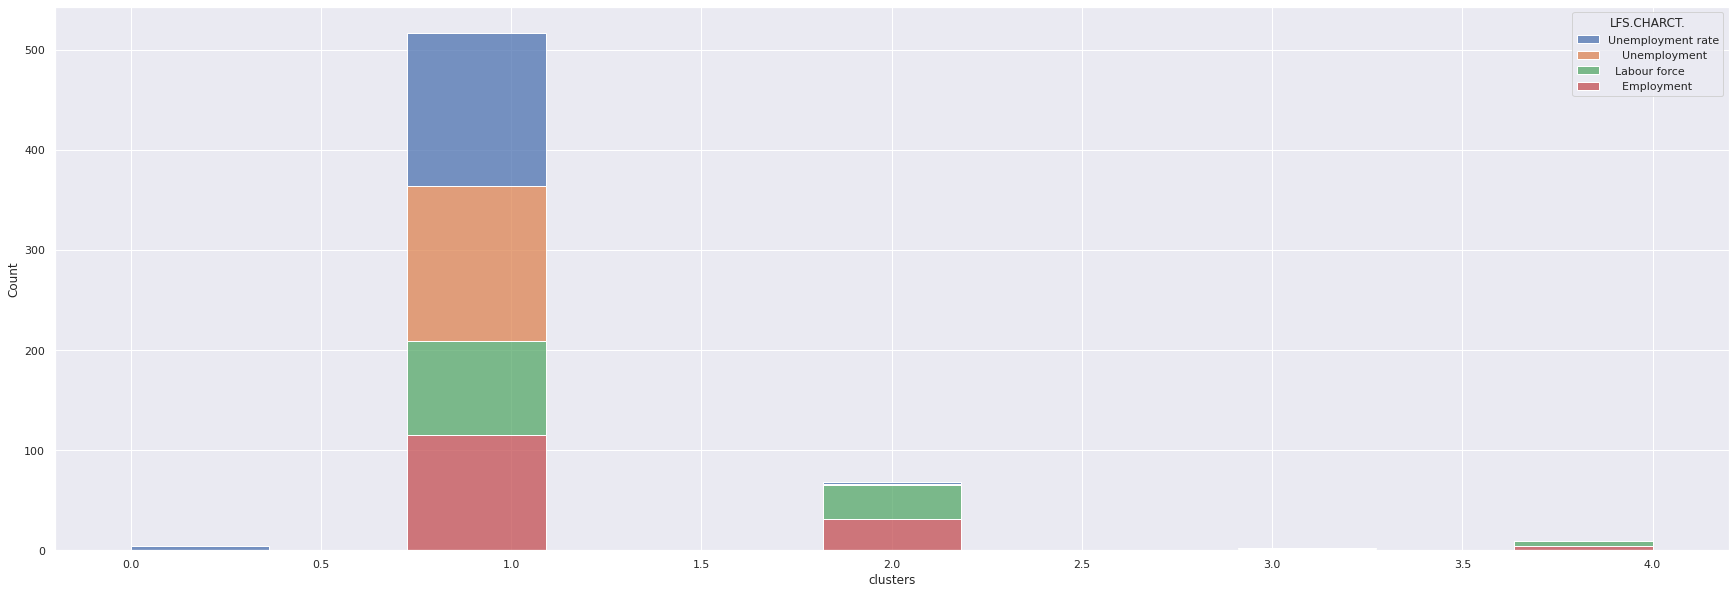

In [ ]:
sns.set(rc={'figure.figsize':(30,10)})
sns.histplot(other_dat, x = "clusters", hue = "LFS.CHARCT.",
             multiple = "stack")
plt.show()

### Q: What do you see in this plot?

###Check out individual data points corresponding to the clusters

In [ ]:
other_dat[other_dat['clusters'] == 3]  # we only have 2 points in cluser 3
# this is in contrast to cluster 1- take a look!

,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,clusters
45781,6 - Sales and service occupations,Sep2019,Central region,Employment,2019,3
8623,"1 - Business, finance and administration occup...",Jun2018,Central region,Labour force,2018,3


In [ ]:
clust_df[clust_df['clusters'] == 1]

,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over",clusters
0,-0.182396,0.615783,-0.187446,-0.080486,-0.307276,-0.154673,-0.320777,-0.324760,-0.170757,-0.223579,-0.407214,-0.367155,-0.275404,-0.19794,-0.154594,-0.163896,1
1,-0.182396,-0.283362,-0.404073,-0.390308,-0.307276,-0.154673,-0.429467,-0.430237,-0.170757,-0.223579,-0.407214,-0.367155,-0.275404,-0.19794,-0.409229,-0.406764,1
2,-0.182396,-0.283362,-0.404073,-0.390308,-0.307276,-0.154673,-0.429467,-0.430237,-0.170757,-0.223579,-0.407214,-0.367155,-0.275404,-0.19794,-0.409229,-0.406764,1
3,-0.182396,-0.283362,-0.404073,-0.390308,-0.307276,-0.154673,-0.220782,-0.240378,-0.170757,-0.223579,-0.407214,-0.367155,-0.275404,-0.19794,-0.409229,-0.406764,1
4,-0.182396,-0.283362,-0.337419,-0.390308,-0.307276,-0.154673,-0.364253,-0.366951,0.152513,-0.223579,-0.104421,-0.215812,-0.275404,-0.19794,-0.107622,-0.113399,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.182396,-0.092293,-0.170782,-0.390308,-0.307276,-0.154673,-0.199044,-0.196078,-0.170757,-0.223579,-0.407214,-0.367155,-0.275404,-0.19794,-0.369674,-0.368290,1
596,-0.182396,-0.283362,-0.404073,-0.390308,-0.307276,-0.154673,-0.429467,-0.430237,-0.170757,-0.223579,-0.407214,-0.367155,-0.275404,-0.19794,-0.409229,-0.406764,1
597,-0.182396,-0.283362,-0.404073,-0.390308,-0.307276,-0.154673,-0.429467,-0.430237,-0.170757,-0.223579,-0.407214,-0.367155,-0.275404,-0.19794,-0.409229,-0.406764,1
598,0.031525,1.155269,0.708227,0.759296,0.028912,-0.154673,0.850901,0.816501,-0.170757,0.231351,0.450699,0.158094,-0.016809,-0.19794,0.352204,0.365124,1


#Hierarchical clustering

###First, for hierarchical clustering, we want to assess the dendrogram of our data.

###Because we have options for different linkage conditions, we may want to assess the impact here or think carefully about our own data and which linkage type AND distance metric is most likely to be appropriate.

###Which distance metric and linkage type should we choose here and why? 

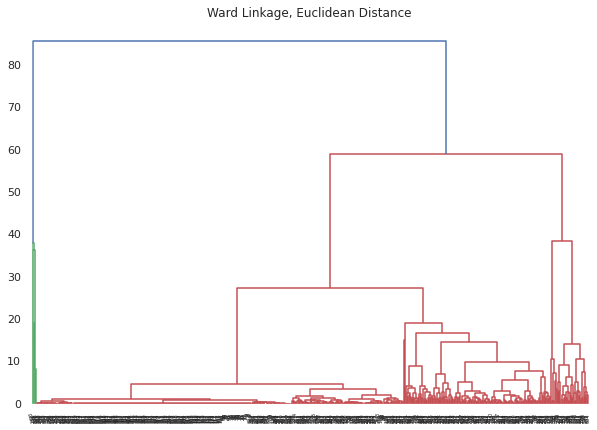

In [ ]:
# sys.setrecursionlimit(10000)
# We'll start with the most common choice - ward linkage and euclidean distance
# You can think about ward linkage as an average between ward and euclidean
plt.figure(figsize=(10,7))
plt.title("Ward Linkage, Euclidean Distance")
dend = dendrogram(linkage(scaled_feat, method = "ward", metric = "euclidean"))

### What do you see for the top split?

In [ ]:
# There is one small cluster and another very large cluster

###Some other distance metrics and linkage options

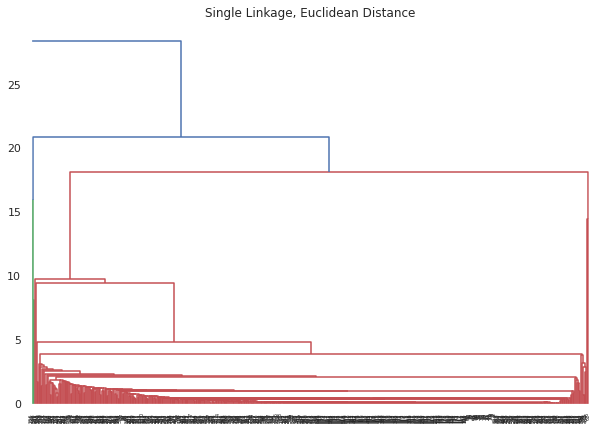

In [ ]:
# Let's change the linkage function
plt.figure(figsize=(10,7))
plt.title("Single Linkage, Euclidean Distance")
dend = dendrogram(linkage(scaled_feat, method = "single", metric = "euclidean"))
# Note we see a very similar pattern as the ward linkage here

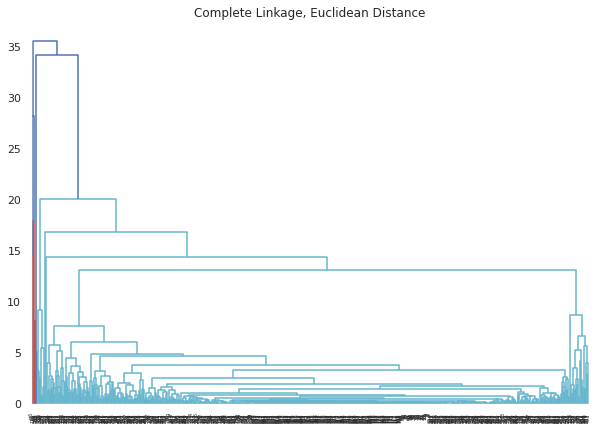

In [ ]:
plt.figure(figsize=(10,7))
plt.title("Complete Linkage, Euclidean Distance")
dend = dendrogram(linkage(scaled_feat, method = "complete", metric = "euclidean"))

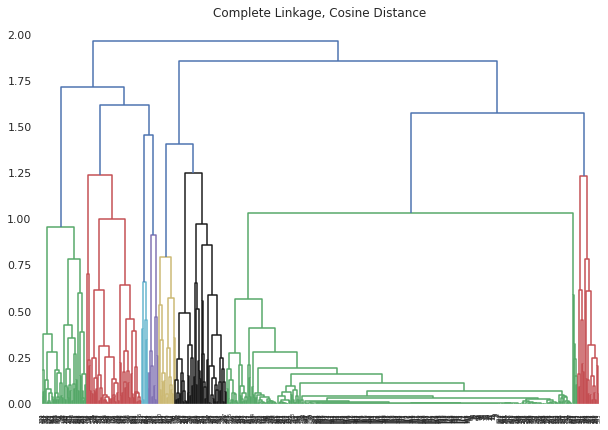

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Complete Linkage, Cosine Distance')
dend = dendrogram(linkage(scaled_feat, method = "complete", metric = "cosine")) 
## Cosine distance - the idea is to treat rows like a vector and find a small angle between them

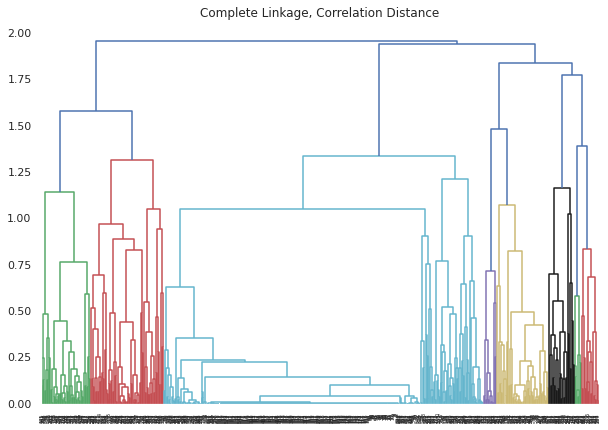

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Complete Linkage, Correlation Distance')
dend = dendrogram(linkage(scaled_feat, method = "complete", metric = "correlation"))

###Now with our distance metric and linkage chosen, let's generate clusters and make sense of them

In [ ]:
# Lets focus on the cosin and complete combination and make a silhouette plot 
# to help choose k
sil_coefs_2 = []
clust_labels_2 = []

for k in range(2, 15):
  print("clustering with " + str(k) + " clusters")
  hcluster = AgglomerativeClustering(n_clusters=k, affinity="cosine",linkage="complete")
  h_clusts = hcluster.fit_predict(scaled_feat)
  clust_labels_2.append(h_clusts)
  score = silhouette_score(scaled_feat, h_clusts)
  sil_coefs_2.append(score)

clustering with 2 clusters
clustering with 3 clusters
clustering with 4 clusters
clustering with 5 clusters
clustering with 6 clusters
clustering with 7 clusters
clustering with 8 clusters
clustering with 9 clusters
clustering with 10 clusters
clustering with 11 clusters
clustering with 12 clusters
clustering with 13 clusters
clustering with 14 clusters


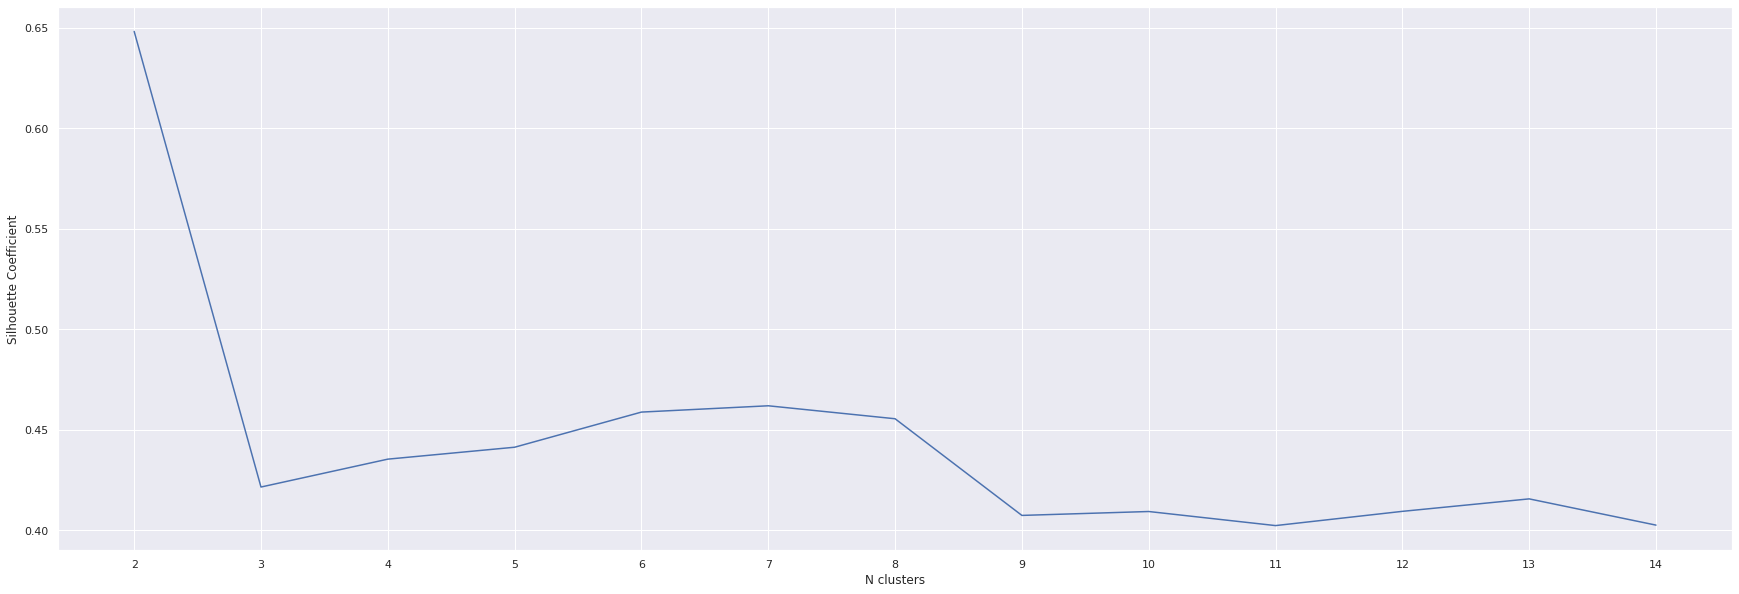

In [ ]:
# Let's take a look at the silhouette statistic 
plt.plot(range(2,15), sil_coefs_2)
plt.xticks(range(2,15))
plt.xlabel("N clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
# Let's focus on the cosin and complete combination with the 8 selected clusters (we'd also want to take a look at 2 clusters)
hcluster = AgglomerativeClustering(n_clusters=8, affinity="cosine",linkage="complete")
h_clusts = hcluster.fit_predict(scaled_feat)

In [ ]:
# Note h_clusts are the labels
h_clusts

array([7, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 3, 0, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 5, 3, 2, 0, 3,
       2, 2, 2, 0, 2, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 2, 7, 2,
       4, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 0,
       7, 2, 0, 1, 1, 2, 3, 0, 1, 0, 3, 2, 2, 3, 1, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 4, 2, 2, 2, 2, 5, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 0,
       2, 2, 2, 2, 2, 4, 3, 2, 7, 2, 1, 2, 7, 1, 2, 0, 3, 2, 3, 2, 2, 2,
       2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 3, 7, 2, 4, 2, 3, 2, 2, 2, 3, 7, 0,
       3, 3, 2, 2, 2, 1, 2, 7, 2, 2, 3, 0, 2, 1, 2, 2, 7, 0, 6, 4, 2, 2,
       1, 2, 2, 3, 7, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 2, 2, 2,
       2, 3, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 3, 2, 2,
       2, 3, 4, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 4, 2, 2, 2, 2, 4, 6, 2,
       0, 2, 1, 2, 2, 0, 2, 5, 7, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3,
       3, 6, 1, 2, 2, 2, 1, 3, 2, 5, 0, 2, 4, 1, 7,

###Concatenate cluster labels with data used for clustering to see what your clusters look like

In [ ]:
hclust_df = pd.DataFrame(data=scaled_feat,columns=features.columns)
hclust_df = hclust_df.astype(float)
hclust_df = hclust_df.assign(clusters = h_clusts)

hclust_mean_df = hclust_df.groupby(['clusters']).mean()

hclust_mean_df

,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over"
clusters,,,,,,,,,,,,,,,,
0,-0.143706,-0.055510,0.138254,0.135797,0.037120,-0.075791,0.151531,0.148314,-0.170757,-0.215928,-0.272334,-0.245433,-0.226318,-0.197940,-0.251639,-0.251075
1,0.856294,1.035637,0.780319,0.663945,0.978869,0.652289,0.782334,0.790292,1.268558,1.575516,2.063455,1.904497,1.707452,1.174001,2.075653,2.066791
2,-0.169618,-0.274471,-0.372961,-0.371543,-0.303592,-0.154673,-0.384248,-0.384932,-0.159521,-0.210551,-0.366361,-0.341225,-0.264951,-0.197940,-0.359295,-0.357425
3,-0.009834,0.584129,1.951371,2.036190,1.327404,0.598389,2.006164,2.006323,-0.167117,-0.021414,0.586646,0.551804,0.281262,0.125505,0.504824,0.500323
4,-0.162325,-0.260883,-0.183823,-0.143230,-0.216652,-0.052498,-0.194035,-0.189933,-0.147008,-0.096990,0.291184,0.281568,0.104169,-0.197940,0.235259,0.228791
5,2.223650,0.425838,-0.225772,-0.343020,-0.263092,-0.154673,-0.175567,-0.183632,0.704300,0.240450,0.019219,-0.124116,-0.199894,-0.197940,0.049361,0.040258
6,0.327074,0.171830,-0.171303,-0.011184,0.006099,0.045871,-0.159100,-0.144131,0.243084,0.336554,0.162415,0.467457,0.240494,2.548392,0.191512,0.223250
7,0.047788,0.969196,-0.023586,0.046795,-0.139716,-0.154673,-0.003160,-0.012900,-0.142889,-0.183773,-0.289742,-0.327588,-0.235753,-0.197940,-0.276830,-0.277315


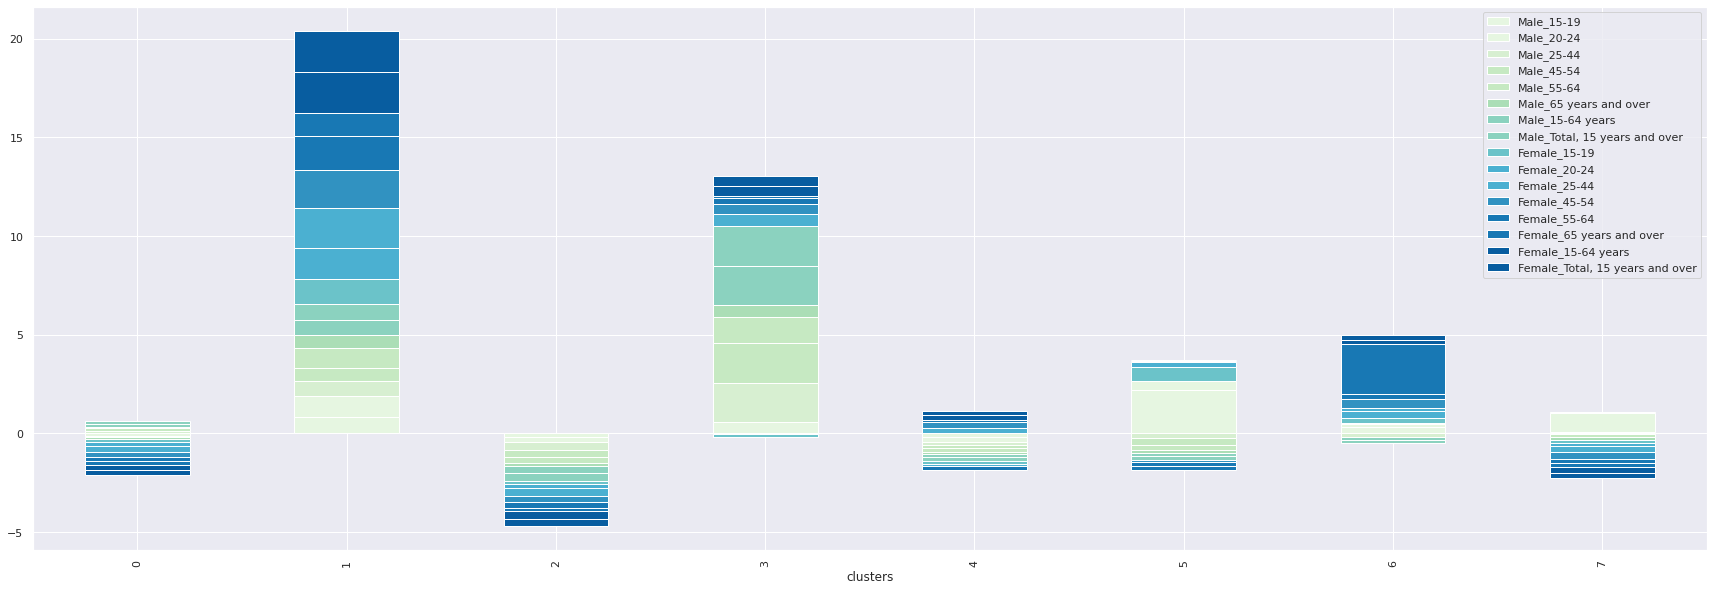

In [ ]:
sns.set()
hclust_mean_df.plot(kind='bar',
                   stacked=True,
                   colormap=ListedColormap(sns.color_palette("GnBu", 10)),
                   figsize=(30,10))
plt.show()

### Q: What do you notice in the plot?

###Now concatenate cluster labels with the other data to see if there are some other patterns in the clusters

In [ ]:
# Let's look at the data to get a better sense
hother_dat = data_sub.iloc[:, :5]
hother_dat = hother_dat.assign(clusters = h_clusts)
hother_dat.clusters.astype(str)
hother_dat.set_index('clusters')

hother_dat.head()

,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,clusters
56640,"7 - Trades, transport and equipment operators ...",Sep2008,Western region,Unemployment rate,2008,3
34586,41 - Professional occupations in law and socia...,Sep2012,Eastern region,Unemployment,2012,11
37286,43 - Occupations in front-line public protecti...,Mar2009,Eastern region,Unemployment,2009,11
49968,64 - Sales representatives and salespersons - ...,Mar2011,Eastern region,Unemployment rate,2011,11
38327,"44 - Care providers and educational, legal and...",Jun2002,Eastern region,Labour force,2002,11


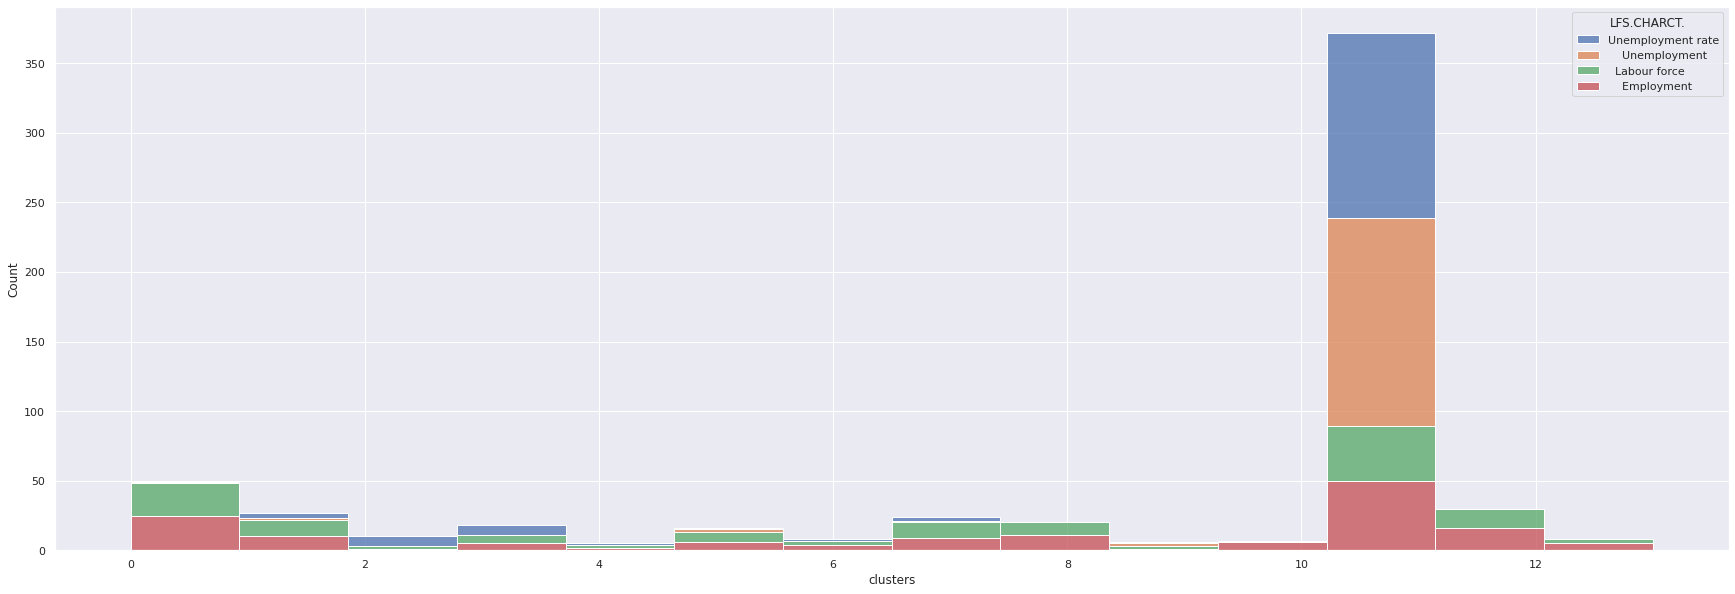

In [ ]:
# We can also investigate across all the different employment types types
sns.set(rc={'figure.figsize':(30,10)})
sns.histplot(hother_dat, x = "clusters", hue = "LFS.CHARCT.",
             multiple = "stack")
plt.show()

###Check out individual points in the data

In [ ]:
# Again, you can investigate specific clusters to get a better sense of what is driving the clusters
# For example, cluster 3 is dominated by trades and the male workforce
# When we do this in practice, we often look for some explanation from the data or else it is 
# hard for people to "buy in to your method" - this is a long process since clustering is a bit hand wavy!
hother_dat[hother_dat['clusters'] == 3]

,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,clusters
56640,"7 - Trades, transport and equipment operators ...",Sep2008,Western region,Unemployment rate,2008,3
65237,"8 - Natural resources, agriculture and related...",Jun2004,Western region,Employment,2004,3
60063,"74 - Other installers, repairers and servicers...",Dec2002,Central region,Labour force,2002,3
63203,"76 - Trades helpers, construction labourers an...",Dec2001,Central region,Labour force,2001,3
48387,63 - Service supervisors and specialized servi...,Mar2011,Eastern region,Labour force,2011,3
19244,21 - Professional occupations in natural and a...,Dec2015,Central region,Unemployment rate,2015,3
64380,"76 - Trades helpers, construction labourers an...",Mar2020,Western region,Unemployment rate,2020,3
56668,"7 - Trades, transport and equipment operators ...",Sep2010,Eastern region,Unemployment rate,2010,3
56340,"7 - Trades, transport and equipment operators ...",Mar2013,Western region,Unemployment rate,2013,3
63463,"76 - Trades helpers, construction labourers an...",Dec2014,Central region,Labour force,2014,3
